In [1]:
!nvidia-smi

Mon Aug  9 07:04:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

data_folder='/content'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
cifar=datasets.CIFAR10(data_folder, download=True, train=True)
tr_data=cifar.data
tr_targets=cifar.targets

val_cifar=datasets.CIFAR10(data_folder, download=True, train=False)
val_data=val_cifar.data
val_targets=val_cifar.targets

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from numpy import moveaxis
from numpy import asarray
from PIL import Image

In [5]:
tr_images=[]
for i in range(0, 50000):
  img=tr_data[i]
  data=asarray(img)
  data = moveaxis(data, 2, 0)
  tr_images.append(data)

tr_images=np.array(tr_images)

In [6]:
val_images=[]
for i in range(0, 10000):
  img=val_data[i]
  data=asarray(img)
  data = moveaxis(data, 2, 0)
  val_images.append(data)

val_images=np.array(val_images)

In [7]:
print(tr_images.shape)
print(val_images.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [8]:
from imgaug import augmenters as iaa
aug=iaa.Sequential([
                    iaa.Affine(translate_px={'x':(-2, 2)}, mode='constant'),
])

In [9]:
class CIFAR(Dataset):
  def __init__(self, x, y, aug=None):
    self.x=x
    self.y=y
    self.aug=aug
  def __getitem__(self, ix):
    x=self.x[ix]
    y=self.y[ix]
    return x, y
  def __len__(self):
    return len(self.x)
  def collate_fn(self, batch):
    ims, classes=list(zip(*batch))
    ims=self.aug.augment_images(images=ims)
    ims=torch.tensor(ims).to(device)/255
    classes=torch.tensor(classes).to(device)
    return ims, classes

In [10]:
from torch.optim import SGD, Adam
def get_model():
  model=nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Conv2d(64, 128, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Conv2d(128, 256, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Dropout(0.4),
      nn.Flatten(),
      nn.Linear(1024, 200),
      nn.ReLU(),
      nn.Linear(200, 10)).to(device)

  loss_fn=nn.CrossEntropyLoss()
  optimizer=Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [11]:
def train_batch(x, y, model, optimizer, loss_fn):
  model.train()
  prediction=model(x)
  batch_loss=loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [12]:
@torch.no_grad()
def value_loss(x, y, model, loss_fn):
  model.eval()
  prediction=model(x)
  val_loss=loss_fn(prediction, y)
  return val_loss.item()

In [13]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()

In [14]:
def get_data():
  train=CIFAR(tr_images, tr_targets, aug)
  train_dl=DataLoader(train, batch_size=64, collate_fn=train.collate_fn, shuffle=True)
  val=CIFAR(val_images, val_targets, aug)
  val_dl=DataLoader(val, batch_size=64, collate_fn=val.collate_fn, shuffle=True)
  return train_dl, val_dl

## Training the Model

In [15]:
train_loss, train_accuracy=[], [] #For training
val_loss, val_accuracy=[], [] #For evaluation
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
for epoch in range(45):
    print(epoch)
    batch_losses_in_epoch, batch_accuracy_epoch=[], []  #For training
    val_batch_losses_in_epoch, val_batch_accuracy_epoch=[], []  #For evaluation
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        batch_losses_in_epoch.append(batch_loss)
        batch_accuracy_epoch.extend(is_correct)
    mean_batch_loss=np.mean(batch_losses_in_epoch)
    epoch_accuracy=np.mean(batch_accuracy_epoch)
    train_loss.append(mean_batch_loss)
    train_accuracy.append(epoch_accuracy)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_batch_loss = value_loss(x, y, model, loss_fn)
        is_correct = accuracy(x, y, model)
        val_batch_losses_in_epoch.append(val_batch_loss)
        val_batch_accuracy_epoch.extend(is_correct)
    mean_batch_loss=np.mean(val_batch_losses_in_epoch)
    epoch_accuracy=np.mean(val_batch_accuracy_epoch)
    val_loss.append(mean_batch_loss)
    val_accuracy.append(epoch_accuracy)

0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


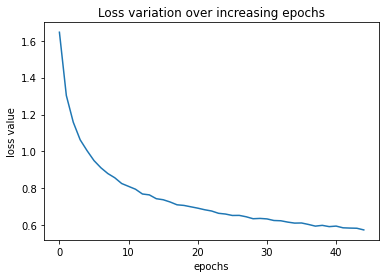

In [16]:
plt.plot(train_loss)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

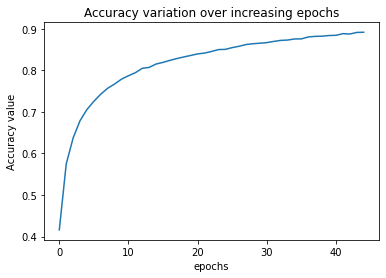

In [17]:
plt.plot(train_accuracy)
plt.title('Accuracy variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('Accuracy value')
plt.show()

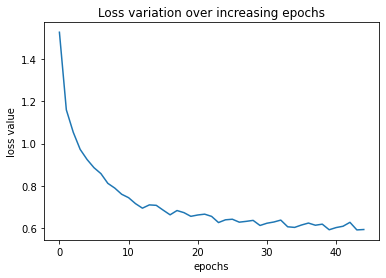

In [18]:
plt.plot(val_loss)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

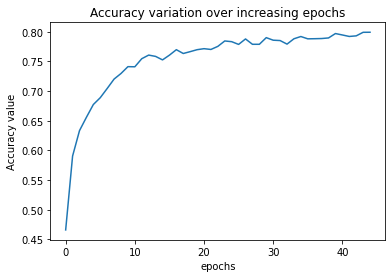

In [19]:
plt.plot(val_accuracy)
plt.title('Accuracy variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('Accuracy value')
plt.show()

## Prediction

In [20]:
img1=tr_images[24311]/255
data=asarray(img1)
data=moveaxis(data, 0, 2)
img2=torch.tensor(img1, dtype=torch.float32).reshape(-1,3,32,32).to(device)
np_output=model(img2)
np_output=np_output.detach().cpu().numpy()
print(np_output)

[[-3.3586943  -3.918692   -3.2930074  -0.34198335 -0.72969127  1.6033062
  -5.0855722   8.319359   -2.8617759  -2.4592211 ]]


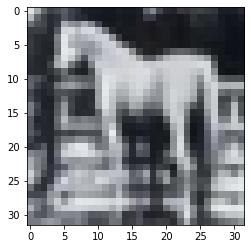

In [21]:
plt.imshow(data)

In [22]:
print(tr_targets[24311])

7
